# Land Cover Classification of RGB Satellite Images

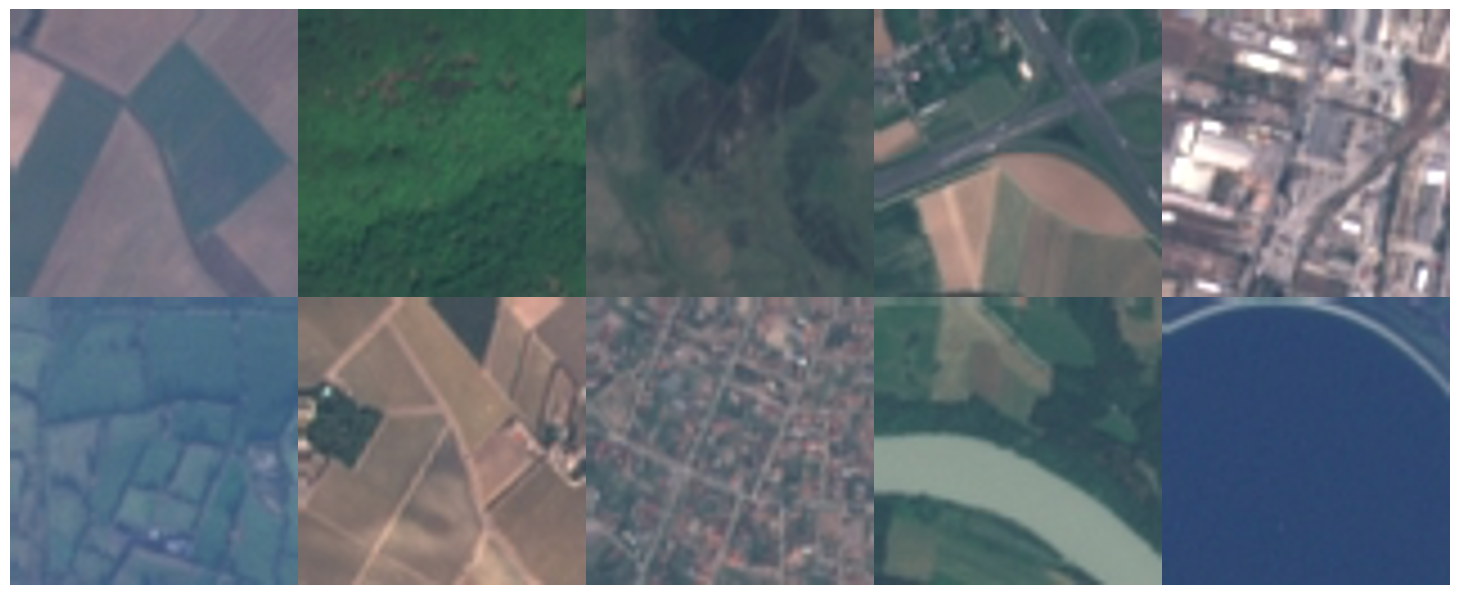

*Samples of each of the Land Cover Classes; from top left- Annual Crop, Forest, Herbaceous Vegetation, Highway, Industrial, Pasture, Permanent Crop, Residential, River, Sea or Lake*

## Overview

A deep learning (neural network) land cover classification project using RGB satellite images (remote sensing) across 10 classes.

## Data Understanding

For this project, I am using RGB satellite images from [EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification](https://zenodo.org/record/7711810#.ZCtEhOzMJQK).

This dataset contains 27,000 RGB Satellite Images across 10 classes:
data set path - data/split/train/(10 folders of 10 classes)
test data path - data/split/test/ (10 folders of 10 classes)
- Annual Crop
- Forest
- Herbaceous Vegetation
- Highway
- Industrial
- Pasture
- Permanent Crop
- Residential
- River
- Sea or Lake <br><br>

There are about 2,500 images per class.

In [1]:
#Import needed libraries
import os, shutil
from PIL import Image, ImageOps

#Standard Libraries
import numpy as np
import pandas as pd

# Visualizations
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report, ConfusionMatrixDisplay

#TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras import models, layers, optimizers, regularizers
from tensorflow.keras import Model
from tensorflow.data.experimental import cardinality
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense # creates densely connected layer object
from tensorflow.keras.layers import Flatten # takes 2D input and turns into 1D array
from tensorflow.keras.layers import Conv2D # convolution layer
from tensorflow.keras.layers import MaxPooling2D # max pooling layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Transfer Learning for further implementation
# from keras.applications import ResNet50, VGG19, VGG16

### Import Data and Train/Validation/Test Split

Since the data is only available as one folder containing subclass folders of each image class, we have to split the data into train and test sets before importing it. 

In [3]:
train_folder = 'data/split/train'
test_folder = 'data/split/test'

# Normalize images
train_gen = ImageDataGenerator(rescale=1./255, validation_split = 0.125)
test_gen = ImageDataGenerator(rescale=1./255)

#Import data as 70% Train (10% Validation of orginal data set) and 20% Test
train_generator = train_gen.flow_from_directory(train_folder,
                                                class_mode = 'categorical', 
                                                subset ='training', 
                                                batch_size=128,
                                                shuffle=True,
                                                seed=42)
                                               
val_generator= train_gen.flow_from_directory(train_folder,
                                             class_mode= 'categorical',
                                             subset = "validation",
                                             batch_size=128,
                                             shuffle=True,
                                             seed=42)

test_generator= test_gen.flow_from_directory(test_folder,
                                              class_mode= 'categorical',
                                              batch_size=128,
                                              shuffle=False,
                                              seed=42)

Found 18900 images belonging to 10 classes.
Found 2700 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [4]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

### Explore Data

Let's look at our image counts of each class across the train, validation, and test datasets.

In [5]:
#Confirm class balance for train and test
train_classes = train_generator.classes
val_classes = val_generator.classes
test_classes = test_generator.classes

#Look at image distribution by class across train, test, and validation sets.
train_class, train_count = np.unique(train_classes, return_counts=True)
val_class, val_count = np.unique(val_classes, return_counts=True)
test_class, test_count = np.unique(test_classes, return_counts=True)

print('Train ~ {}'.format(list(zip(train_class, train_count))))
print('Validation ~ {}'.format(list(zip(val_class, val_count))))
print('Test ~ {}'.format(list(zip(test_class, test_count))))

Train ~ [(0, 2100), (1, 2100), (2, 2100), (3, 1750), (4, 1750), (5, 1400), (6, 1750), (7, 2100), (8, 1750), (9, 2100)]
Validation ~ [(0, 300), (1, 300), (2, 300), (3, 250), (4, 250), (5, 200), (6, 250), (7, 300), (8, 250), (9, 300)]
Test ~ [(0, 600), (1, 600), (2, 600), (3, 500), (4, 500), (5, 400), (6, 500), (7, 600), (8, 500), (9, 600)]


In [6]:
#Checking the classes in our train data 
train_class_names = train_generator.class_indices
print('Train:', train_class_names)

#Checking the classes in our validation data
val_class_names = val_generator.class_indices
print('Validation:', val_class_names)

#Checking the classes in our test data
test_class_names = test_generator.class_indices
print('Train:', test_class_names)

Train: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}
Validation: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}
Train: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [7]:
# Preview the shape of both the images and labels for both the train, validation, and test sets (8 objects total)
print("Train")
print(np.shape(train_images))
print(np.shape(train_labels))
print("Validation")
print(np.shape(val_images))
print(np.shape(val_labels))
print("Test")
print(np.shape(test_images))
print(np.shape(test_labels))

Train
(128, 256, 256, 3)
(128, 10)
Validation
(128, 256, 256, 3)
(128, 10)
Test
(128, 256, 256, 3)
(128, 10)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


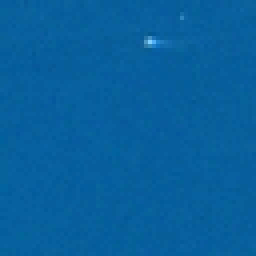

In [8]:
# Preview a train data image
print(train_labels[0])
array_to_img(train_images[0])

The above image is an example of the "Sea or Lake" class.

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


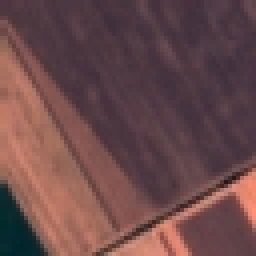

In [9]:
# Preview a test data image
print(test_labels[0])
array_to_img(test_images[0])

The above image is an example of the "Industrial" class.

## Modeling

### Baseline Model

For our baseline model, we will create a simple Sequential Neural Network with one Convolutional Layer, one Max Pooling Layer, and one Dense Layer (not including our output layer). 

In [10]:
#Instantiate a Sequential model
baseline_model = Sequential()


# Input Layer- Convolution
baseline_model.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu',
                          input_shape= (256, 256, 3)))


# Layer 1- max pool in 2x2 window
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2- connect all nodes with dense layer
baseline_model.add(Flatten())
baseline_model.add(Dense(64, activation='relu'))

# Output Layer- softmax activiation for multi-categorical with 10 classes
baseline_model.add(Dense(10, activation='softmax'))

#Compile the sequential CNN model- adam optimizer, 
# categorical_crossentropy loss, and set our metric to accuracy
baseline_model.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
baseline_model.summary()

c:\Users\omkol\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 516128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    33,032,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,033,802 (126.01 MB)

 Trainable params: 33,033,802 (126.01 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
#Fit the model 
baseline_history = baseline_model.fit(train_generator, 
                                      epochs = 20, 
                                      batch_size= 128, 
                                      verbose = 1, 
                                      validation_data = val_generator)

Epoch 1/20


c:\Users\omkol\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


148/148 ━━━━━━━━━━━━━━━━━━━━ 891s 6s/step - accuracy: 0.2147 - loss: 6.8996 - val_accuracy: 0.3767 - val_loss: 1.6420
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 621s 4s/step - accuracy: 0.4152 - loss: 1.5693 - val_accuracy: 0.4759 - val_loss: 1.4463
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 959s 6s/step - accuracy: 0.5095 - loss: 1.3796 - val_accuracy: 0.5096 - val_loss: 1.3108
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 460s 3s/step - accuracy: 0.5723 - loss: 1.1961 - val_accuracy: 0.6144 - val_loss: 1.1248
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 506s 3s/step - accuracy: 0.6360 - loss: 1.0406 - val_accuracy: 0.5663 - val_loss: 1.1343
Epoch 6/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 991s 7s/step - accuracy: 0.6498 - loss: 0.9765 - val_accuracy: 0.6685 - val_loss: 0.9615
Epoch 7/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 676s 4s/step - accuracy: 0.6874 - loss: 0.8803 - val_accuracy: 0.6819 - val_loss: 0.8996
Epoch 8/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 796s 5s/step - accuracy: 0.7219 - loss: 0.8013 - val_accuracy: 0.680

In [ ]:
#Check loss and accuracy on test data
test_loss, test_acc = baseline_model.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 25s 585ms/step - loss: 1.0459 - accuracy: 0.7411
Test loss:  1.0459473133087158
Test accuracy:  0.7411110997200012


It looks like after 20 Epochs our baseline model overfit with a 96.4% train accuracy and a 74.1% test accuracy. In the future, we will also want to use Early Stopping to prevent the model from continuing to overfit. 

Let's make our CNN "deeper" and add additonal convolution and max pooling layers.

In [ ]:
#Instantiate a Sequential model
model_one = Sequential()


# Input Layer- Convolution
model_one.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu',
                          input_shape= (256, 256, 3)))


# Layer 1- max pool in 2x2 window
model_one.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2- another convolution layer 
model_one.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Layer 3- another max pool layer
model_one.add(layers.MaxPooling2D((2, 2)))

# Layer 4- connect all nodes with dense layer
model_one.add(Flatten())
model_one.add(Dense(64, activation='relu'))

# Output Layer- softmax activiation for multi-categorical with 10 classes
model_one.add(Dense(10, activation='softmax'))

#Compile the sequential CNN model- adam optimizer, 
# categorical_crossentropy loss, and set our metric to accuracy
model_one.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
model_one.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 123008)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                7872576   
_________________________________________________________________
dense_9 (Dense)              (None, 10)               

Let's also add a stopping criteria as well.

In [ ]:
# Define Stopping Criteria 
valcallback = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 2)


# Fit the model
model_one_history = model_one.fit(train_generator, 
                                  epochs= 20, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
148/148 [==============================] - 444s 3s/step - loss: 1.5299 - accuracy: 0.4476 - val_loss: 1.1410 - val_accuracy: 0.5926
Epoch 2/20
148/148 [==============================] - 452s 3s/step - loss: 1.0054 - accuracy: 0.6348 - val_loss: 0.9596 - val_accuracy: 0.6463
Epoch 3/20
148/148 [==============================] - 449s 3s/step - loss: 0.8038 - accuracy: 0.7134 - val_loss: 0.8036 - val_accuracy: 0.6993
Epoch 4/20
148/148 [==============================] - 490s 3s/step - loss: 0.6379 - accuracy: 0.7755 - val_loss: 0.7442 - val_accuracy: 0.7374
Epoch 5/20
148/148 [==============================] - 553s 4s/step - loss: 0.5075 - accuracy: 0.8248 - val_loss: 0.6600 - val_accuracy: 0.7711
Epoch 6/20
148/148 [==============================] - 451s 3s/step - loss: 0.4197 - accuracy: 0.8556 - val_loss: 0.7485 - val_accuracy: 0.7367
Epoch 7/20
148/148 [==============================] - 440s 3s/step - loss: 0.3318 - accuracy: 0.8915 - val_loss: 0.6621 - val_accuracy: 0.7807

In [ ]:
#Check loss and accuracy on test data
test_loss, test_acc = model_one.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 36s 827ms/step - loss: 0.6744 - accuracy: 0.7857
Test loss:  0.6743987798690796
Test accuracy:  0.7857407331466675


Making our model deeper and adding early stopping seemed to help; our model stopped after 7 Epochs once validation loss stopped decreasing. Our model is still overfit but less so with a 89.2% Train accuracy and a 78.6% Test accuracy.